In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print(tf.__version__)
# Print list of all available physical devices (including GPUs)
physical_devices = tf.config.list_physical_devices()
print("Available Physical Devices:", physical_devices)

# Print list of all available logical devices
logical_devices = tf.config.list_logical_devices()
print("Available Logical Devices:", logical_devices)

# Check if GPU is available
gpu_available = tf.config.experimental.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and recognized by TensorFlow.")
else:
    print("No GPU is available or TensorFlow doesn't recognize the GPU.")

2.10.0
Available Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Available Logical Devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
No GPU is available or TensorFlow doesn't recognize the GPU.


In [2]:
import numpy as np
import cv2,os,math,keras,torch
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
def imresize(array,shape):
    resized_images = np.empty((array.shape[0], shape, shape), dtype=array.dtype)
    for i in range(array.shape[0]):
        # Extract the current image
        current_image = array[i, :, :]  # Assuming the channel axis is the last one
        # Resize the image using cv2.resize
        resized_image = cv2.resize(current_image, (shape, shape), interpolation=cv2.INTER_LINEAR)
        # Add the resized image to the new array
        resized_images[i, :, :] = resized_image

    return resized_images

data_size = 960
x_test = np.load(f'C:/Users/Unknown/Documents/VSCode/Jupyter/Validation{data_size}_half.npy')
output_size=640,640
resize=1
if resize:
    shape=output_size[0]
    x_test=imresize(x_test,shape)
x_test=tf.image.convert_image_dtype(x_test,dtype='float16')

#plt.imshow(tf.cast(x_test[0],dtype='float32'))
x_test = tf.expand_dims(x_test, axis=-1)
#confirm they are idential except N
print(x_test.shape)
print(x_test.dtype)

def PropagationLayer(input,mode=None):#Angular spectrum method for input or output
    input=tf.cast(input,dtype='float32')#estimated POH itself
    inputs=Input((output_size[0],output_size[1],1))
    input=tf.squeeze(input, axis=-1)#to eliminate calculation error in ASM
    lamda = 532e-9 #lambda is the reserved word
    dp = 8e-6 #pixel size of SLM you use
    z = 100e-3 #propagation distance you assume
    pad_m = inputs.shape[1] // 2
    pad_n = inputs.shape[2] // 2
    if mode=="input":
        padded_real = tf.math.cos(input)
        padded_imaginary = tf.math.sin(input)
        z = -z #propagation distance,bu reverse direction
    else: #input is 0 to 1 data by sigmoid
        padded_real = tf.math.cos(2*math.pi*input)
        padded_imaginary = tf.math.sin(2*math.pi*input)
    inputsc = tf.complex(padded_real, padded_imaginary)#complex amp of POH, same as exp(1j*...)
    Lx = dp * inputs.shape[2]
    Ly = dp * inputs.shape[1]
    f_max = 0.5 / dp
    du = 1.0 / Lx
    dv = 1.0 / Ly
    x_range = tf.range(-f_max, f_max, du, dtype=tf.float32)
    y_range = tf.range(-f_max, f_max, dv, dtype=tf.float32)
    fx, fy = tf.meshgrid(x_range, y_range)
    FH = tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fftshift(inputsc)))
    real_part = tf.math.cos(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    imaginary_part = tf.math.sin(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    P = tf.complex(real_part, imaginary_part)#normal ASM kernel
    #define frequency limit for sampling theorem
    fx_max = tf.math.divide(inputs.shape[1] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[1]  * dp) ** 2))
    fy_max = tf.math.divide(inputs.shape[2] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[2]  * dp) ** 2))
    P = tf.where(tf.math.logical_and(tf.abs(fx) < fx_max, tf.abs(fy) < fy_max), x=P, y=0.0)#band-limiting mask for kernal(sampling theorem)

    P = tf.expand_dims(P, axis=0)  # Add a batch dimension
    U = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(FH * P)))#kernel applied in Fourier domain
    if mode=="input":
        U = tf.expand_dims(U, axis=-1)
        asm = tf.concat([tf.math.real(U), tf.math.imag(U)], axis=-1)#complex amp
    else:
        asm = tf.square(tf.abs(U)) #observed info
    return asm

(50, 640, 640, 1)
<dtype: 'float16'>


In [11]:
import time
from openvino.inference_engine import IECore
#import onnx
#from onnx import TensorShapeProto, TensorProto
#modelonx = onnx.load("./Unet_POH_512.onnx")
input_name = "input_1"
output_names = ["hologram"]

Use new API of OpenVINO to deal with dynamic input shape!!!!!!

In [1]:
#!python -m onnxruntime.tools.make_dynamic_shape_fixed --input_name input_1 --input_shape 10,640,640,2 Unet_POH_640v2.onnx Unet_POH_640v2fixed.onnx

In [ ]:
import openvino as ov
convert=1
if convert:
    !ovc Unet_POH_640.onnx
core = ov.Core()
model_path = 'Unet_POH_640.xml'
weight_path = 'Unet_POH_640.bin'
model = core.read_model(model_path)
# Compile the network for the target device
compiled_model = core.compile_model(model, "CPU")
true=x_test[21:31] #NHWC
del x_test

In [14]:
# Perform inference (input_data is your input data in the appropriate format)
#input=PropagationLayer(true,mode="input")
#input=input.numpy()
#true=PropagationLayer(true,mode="input")
infer_request=compiled_model.create_infer_request()
start_time = time.time()
input=PropagationLayer(true,mode="input").numpy()
start_time2 = time.time()
#true= np.transpose(true, (0, 3, 1, 2))#NCHW
holo = infer_request.infer({input_name: input})
end_time = time.time()
inference_time = (end_time - start_time)/(true.shape[0])
inference_time2 = (end_time - start_time2)/(true.shape[0])
print(f"Inference + Data prep time for each image: {inference_time} seconds")#with data prep
print(f"Inference time for each image: {inference_time2} seconds")#inference only
print(f"total inference:{(end_time - start_time)}")
holo = holo['hologram']#take output
#print(holo)

Inference + Data prep time for each image: 1.13388831615448 seconds
Inference time for each image: 0.7161810636520386 seconds
total inference:11.3388831615448


(10, 640, 640, 1)


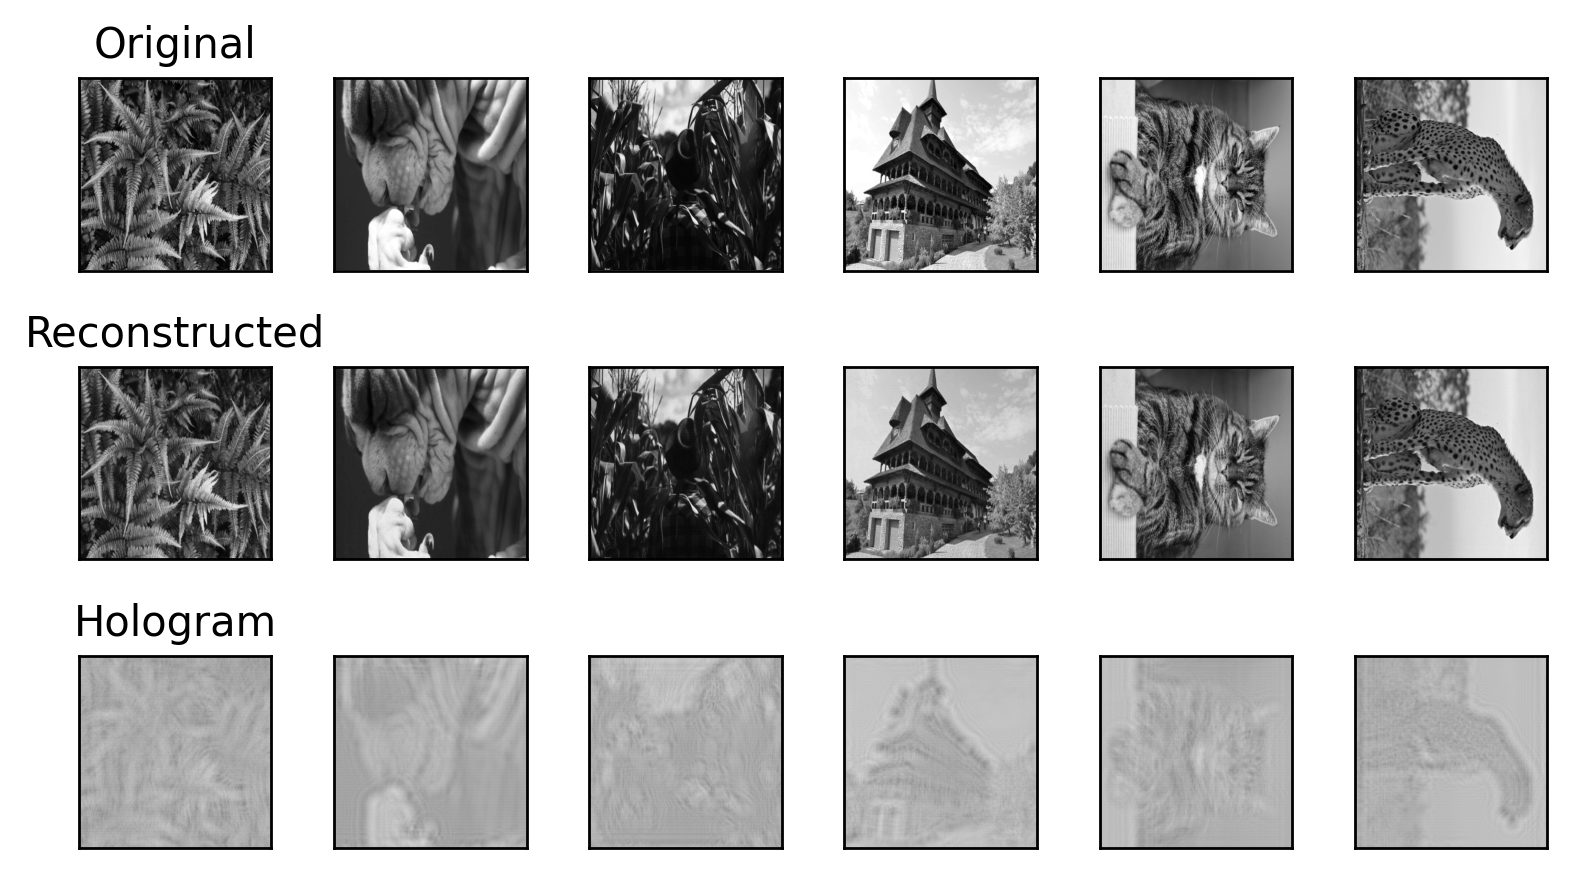

In [15]:
print(holo.shape)
output=PropagationLayer(holo,mode="output")
n = 7
plt.figure(figsize=(n+2, 4), dpi=250)
plt.subplots_adjust(hspace=0.5)
for i in range(1, n):#1 to n-1
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(tf.cast(true[i],dtype='float32'))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Original")  # Set a title for this subplot
    # Display reconstructed image
    ax = plt.subplot(3, n, i + n)
    plt.imshow(output[i])  # Reconstructed one
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Reconstructed")  # Set a title for this subplot
    # Display hologram
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(holo[i])  # Reconstructed one
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==1:
        ax.set_title("Hologram")  # Set a title for this subplot
plt.show()